In [1]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import os

from consav.linear_interp import interp_1d
from consav.linear_interp import interp_2d
from consav.linear_interp import interp_2d_vec

%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from DynLaborModel import DynLaborModelClass

# different models
model = DynLaborModelClass(
    par={'T': 10, 'r': 0.02, 'rho': 1/(1.02), 'alpha': 0.0})
model_cpp = DynLaborModelClass(
    par={'T': 10, 'r': 0.02, 'rho': 1/(1.02), 'alpha': 0.0})
model_cpp.link_to_cpp(force_compile=True,do_print=False)

par = model.par
sol = model.sol
sim = model.sim


terminal:

(base) c:\Users\Simon\HouseholdBehaviorTest>cd /d "C:/Program Files/Microsoft Visual Studio/2022/Community/VC/Auxiliary/Build/" 

(base) C:\Program Files\Microsoft Visual Studio\2022\Community\VC\Auxiliary\Build>call vcvarsall.bat x64 
**********************************************************************
** Visual Studio 2022 Developer Command Prompt v17.5.5
** Copyright (c) 2022 Microsoft Corporation
**********************************************************************
[vcvarsall.bat] Environment initialized for: 'x64'
solve.cpp
setup_omp.cpp
Generating Code...
Microsoft (R) Incremental Linker Version 14.35.32217.1
Copyright (C) Microsoft Corporation.  All rights reserved.

/out:solve.dll 
/dll 
/implib:solve.lib 
solve.obj 
setup_omp.obj 
cppfuncs/nlopt-2.4.2-dll64/libnlopt-0.lib 
LINK : fatal error LNK1104: cannot open file 'solve.dll'

Microsoft (R) C/C++ Optimizing Compiler Version 19.35.32217.1 for x64
Copyright (C) Microsoft Corporation.  All rights reserved.




RuntimeError: C++ files can not be compiled

In [ ]:
model.solve(method='vfi')

In [ ]:
model_cpp.solve(method='cpp')

## Solve the model

#### Difference between cpp and python

[Text(0.5, 0, 'savings'), Text(0, 0.5, 'diff, egm vs. vfi')]

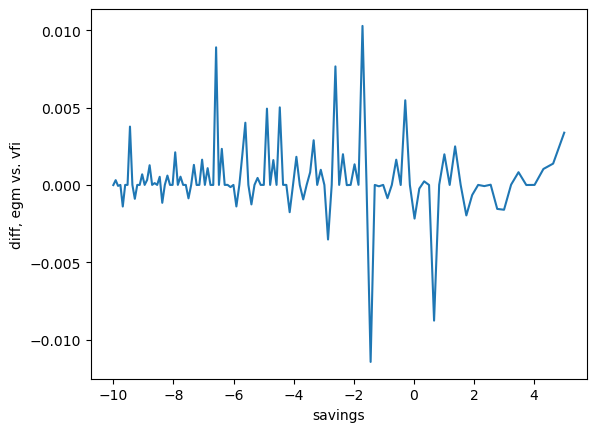

In [ ]:
T = model_cpp.par.T - 2
diff = model.sol.c[T,:,0] - model_cpp.sol.c[T,:,0]

ax = plt.subplot(1,1,1)

ax.plot(par.a_grid, diff)
ax.set(xlabel='savings', ylabel='diff, egm vs. vfi')

# seems a bit unstable, but errors are relatively small..

# Elasticities and Responsiveness

In [ ]:
def calc_frisch(model, method = "vfi"):
    # simulate Frisch elasticity in the 1st period: Anticipated transitory increase in wage
    model.simulate()

    period = 1
    pct = 1
    model_F = model.copy()
    model_F.par.w_vec[period-1] = model_F.par.w_vec[period-1]*(1.0 +pct/100) # increase by 1% in first period -> easiest because we do not need two models

    model_F.solve(method = method)
    model_F.simulate()

    ela_Fi = (model_F.sim.h - model.sim.h)/model.sim.h*100
    # Theoretical if no human capital
    ela_F_noHC = 1/par.gamma
    

    print(f'Theoretical, w. alpha = 0.0:        {ela_F_noHC:2.3f} \nSimulated elasticity, w. alpha={par.alpha:2.1f}: {ela_Fi[0,period-1]:2.3f}')

    # check model solution [first point in human capital grid]
    t = 0
    diff = (model_F.sol.h[t] - model.sol.h[t])/model.sol.h[t]/(pct/100)
    fig, ax = plt.subplots()
    ax.plot(model_F.par.a_grid, diff[:,0]);
    ax.set(xlabel='Wealth, $a_{T}$',ylabel='ela_f');

    return model_F

def calc_marshall(model, method = "vfi"):
    model.simulate()

    # simulate Marshall elasticity in the first period
    model_1pct = model.copy()
    model_1pct.par.w_vec[:] = model_1pct.par.w_vec[:]*1.01

    model_1pct.solve(method = method)
    model_1pct.simulate()

    ela_Mi = (model_1pct.sim.h - model.sim.h)/model.sim.h*100
    # Theoretical Marshall elasticity if \alpha=0
    ela_M_noHC = (1+par.eta) / (par.gamma - par.eta) 

    print(f'Theoretical, w. alpha = 0.0:        {ela_M_noHC:2.3f} \nSimulated elasticity, w. alpha={par.alpha:2.1f}: {ela_Mi[0,0]:2.5}')

In [ ]:
model_F = calc_marshall(model_cpp, method = "egm")

Theoretical, w. alpha = 0.0:        -0.222 
Simulated elasticity, w. alpha=0.0: -0.14804


Theoretical, w. alpha = 0.0:        0.400 
Simulated elasticity, w. alpha=0.0: 0.404


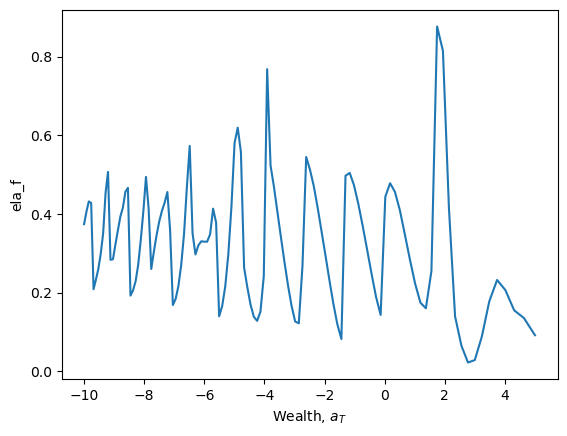

In [ ]:
model_F = calc_frisch(model_cpp, method = "egm")

In [ ]:
model_cpp1 = DynLaborModelClass(par={'T':8,'r':0.02,'rho':1/(1.02),'alpha':0.0}) # set a few number of periods.
model_cpp1.link_to_cpp(force_compile=True,do_print=False)

Na_vec = [80, 90, 100, 110, 120, 130, 200]

Na_vec = [50, 70, 80]


for na in Na_vec:
    model_now = model_cpp1.copy()
    model_now.par.Na = na
    model_now.allocate()

    #os.remove("solve.dll")
    model_now.solve(method = 'cpp')
    calc_marshall(model_now, method='cpp')
    #model.cpp
    #del(model_now)

PermissionError: [WinError 5] Adgang nægtet: 'solve.dll'

In [6]:
del(model_now)
os.remove("solve.obj")

NameError: name 'model_now' is not defined